In [ ]:
#Import packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
#load listings data and review data
listings_replication= 'replication.csv'
listings_label_encoded= 'listings_features_label_encoded.csv'
reviews= 'listings_features_reviews.csv'
sentiment= 'average_sentiment_per_topic_listing.csv'
label_encoded_features = pd.read_csv(listings_label_encoded)
reviews_features = pd.read_csv(reviews)
sentiment_features= pd.read_csv(sentiment)
replication_features= pd.read_csv(listings_replication)



In [25]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full width of column content
pd.set_option('display.max_rows', None)  # Show all rows

Check the shape of these 4 sets of features. We see that the replication deletes listings with prices above $500. Therefore it has less rows than the label encoded and review-related features.
As we can see those 2 have the same data cleaning approach, such that we can easily compare them together as only the features (columns) differ.
The sentiment related features are preprocessed on the reviews and therefore have a different shape, however the download contains the same listings, listings with high prices are not removed, but for example non-english reviews are removed and therefore the number of listings is different.

In [26]:
#Shapes
print('Replication shape:', replication_features.shape)
print('Label encoded shape:', label_encoded_features.shape)
print('Reviews shape:', reviews_features.shape)
print('Sentiment shape:', sentiment_features.shape)

Replication shape: (200361, 12)
Label encoded shape: (210937, 99)
Reviews shape: (210937, 11)
Sentiment shape: (269520, 6)


In [27]:
reviews_features.head()

,id,number_of_reviews,number_of_reviews_l30d,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,days_between_first_review,days_since_last_review
0,888038298563003925,8,0,5.00,4.88,4.75,4.50,4.88,4.75,645,280
1,50666229,165,6,4.87,4.85,4.99,4.98,4.93,4.62,1131,7
2,933523,140,2,4.84,4.93,4.97,4.99,4.91,4.74,3775,7
3,656222143862971193,14,0,4.86,4.86,5.00,5.00,4.93,4.71,750,64
4,20259345,712,7,4.93,4.84,4.92,4.93,4.83,4.77,2356,13


In [28]:
sentiment_features['id']=sentiment_features['listing_id']
sentiment_features.drop(columns=['listing_id'], inplace=True)

In [29]:
#We will merge the sentiment and reviews to get the review-related features and keep sure this are the same listings as in the non-review related feature sets.
reviews_sentiment_features=pd.merge(sentiment_features, reviews_features, on='id', how='inner')
print('Reviews sentiment shape:', reviews_sentiment_features.shape)



Reviews sentiment shape: (201129, 16)


In [30]:
#Keep the same listings in all datasets except for the replication
listings=reviews_sentiment_features['id']
label_encoded_features=label_encoded_features[label_encoded_features['id'].isin(listings)]
reviews_features=reviews_features[reviews_features['id'].isin(listings)]

Reviews data do not include the price right now, we add the price to reviews_data_including price, because it can be useful later on in the research

In [31]:
#Add the price column form label encoded to the reviews_sentiment_features
reviews_sentiment_including_price=pd.merge(reviews_sentiment_features, label_encoded_features[['id','price']], on='id', how='inner')
reviews_features_including_price=pd.merge(reviews_features, label_encoded_features[['id','price']], on='id', how='inner')
print('Reviews sentiment including price shape:', reviews_sentiment_including_price.shape)
print('Reviews including price shape:', reviews_features_including_price.shape)



Reviews sentiment including price shape: (201129, 17)
Reviews including price shape: (201129, 12)


In [32]:
reviews_sentiment_listings_label_encoded= pd.merge(reviews_sentiment_features, label_encoded_features, on='id', how='inner')
reviews_without_sentiment_listings_label_encoded= pd.merge(reviews_sentiment_features, label_encoded_features, on='id', how='inner').drop(columns=['sentiment_topic_0','sentiment_topic_1','sentiment_topic_2','sentiment_topic_3'])


This leads to four different feature sets, with the following shapes. These are the feature sets that we are using for research question 2 and research question 3.

In [33]:
print('Feature set 1:' , label_encoded_features.shape)
print('Feature set 2:' , reviews_without_sentiment_listings_label_encoded.shape)
print('Feature set 3:' , reviews_sentiment_listings_label_encoded.shape)
print('Feature set 4:' , reviews_sentiment_including_price.shape)


Feature set 1: (201129, 99)
Feature set 2: (201129, 110)
Feature set 3: (201129, 114)
Feature set 4: (201129, 17)


We do the same train-test split for those four feature sets.

In [ ]:
# Generate a list of unique listing IDs
listing_ids = list(reviews_sentiment_including_price['id'].unique())  # Assuming all datasets share the same IDs

# Train-test split to generate consistent listing IDs for training and testing
train_ids, test_ids = train_test_split(listing_ids, test_size=0.1, random_state=42)

# Filter each relevant feature set by the train and test IDs
# Train sets
reviews_sentiment_including_price_train = reviews_sentiment_including_price[reviews_sentiment_including_price['id'].isin(train_ids)]
reviews_sentiment_listings_label_encoded_train = reviews_sentiment_listings_label_encoded[reviews_sentiment_listings_label_encoded['id'].isin(train_ids)]
label_encoded_train = label_encoded_features[label_encoded_features['id'].isin(train_ids)]
reviews_without_sentiment_listings_label_encoded_train = reviews_without_sentiment_listings_label_encoded[reviews_without_sentiment_listings_label_encoded['id'].isin(train_ids)]

# Test sets
reviews_sentiment_including_price_test = reviews_sentiment_including_price[reviews_sentiment_including_price['id'].isin(test_ids)]
reviews_sentiment_listings_label_encoded_test = reviews_sentiment_listings_label_encoded[reviews_sentiment_listings_label_encoded['id'].isin(test_ids)]
label_encoded_test = label_encoded_features[label_encoded_features['id'].isin(test_ids)]
reviews_without_sentiment_listings_label_encoded_test = reviews_without_sentiment_listings_label_encoded[reviews_without_sentiment_listings_label_encoded['id'].isin(test_ids)]

We import the extra test set that contains the data of other cities (Madrid+Singapore) that is preprocessed similarly.

In [35]:
extra_test_feature_set1= pd.read_csv('extra_test_set_feature_set1.csv')
extra_test_feature_set2= pd.read_csv('extra_test_set_feature_set2.csv')
extra_test_feature_set3= pd.read_csv('extra_test_set_feature_set3.csv')
extra_test_feature_set4= pd.read_csv('extra_test_set_feature_set4.csv')

In [36]:
#Delete ID column from all feature sets (Train and Test), because it should not have a meaning
reviews_sentiment_including_price_train.drop(columns=['id'], inplace=True)
reviews_sentiment_listings_label_encoded_train.drop(columns=['id'], inplace=True)
label_encoded_train.drop(columns=['id'], inplace=True)
reviews_without_sentiment_listings_label_encoded_train.drop(columns=['id'], inplace=True)
reviews_sentiment_including_price_test.drop(columns=['id'], inplace=True)
reviews_sentiment_listings_label_encoded_test.drop(columns=['id'], inplace=True)
label_encoded_test.drop(columns=['id'], inplace=True)
reviews_without_sentiment_listings_label_encoded_test.drop(columns=['id'], inplace=True)
replication_features.drop(columns=['id'], inplace=True)
extra_test_feature_set1.drop(columns=['id'], inplace=True)
extra_test_feature_set2.drop(columns=['id'], inplace=True)
extra_test_feature_set3.drop(columns=['id'], inplace=True)
extra_test_feature_set4.drop(columns=['id'], inplace=True)




C:\Users\PC\AppData\Local\Temp\ipykernel_4940\4012875122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_sentiment_including_price_train.drop(columns=['id'], inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_4940\4012875122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_sentiment_listings_label_encoded_train.drop(columns=['id'], inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_4940\4012875122.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [37]:
# Train set shapes
print("Train set shapes:")
print("Feature set 1:", label_encoded_train.shape)
print("Feature set 2:", reviews_without_sentiment_listings_label_encoded_train.shape)
print("Feature set 3:", reviews_sentiment_listings_label_encoded_train.shape)
print("Feature set 4", reviews_sentiment_including_price_train.shape)


# Test set shapes
print("\nTest set shapes:")
print("Feature set 1:", label_encoded_test.shape)
print("Feature set 2:", reviews_without_sentiment_listings_label_encoded_test.shape)
print("Feature set 3:", reviews_sentiment_listings_label_encoded_test.shape)
print("Feature set 4", reviews_sentiment_including_price_test.shape)

#Extra test set shapes
print("\nExtra test set shapes:")
print("Feature set 1:", extra_test_feature_set1.shape)
print("Feature set 2:", extra_test_feature_set2.shape)
print("Feature set 3:", extra_test_feature_set3.shape)
print("Feature set 4", extra_test_feature_set4.shape)


Train set shapes:
Feature set 1: (181016, 98)
Feature set 2: (181016, 109)
Feature set 3: (181016, 113)
Feature set 4 (181016, 16)

Test set shapes:
Feature set 1: (20113, 98)
Feature set 2: (20113, 109)
Feature set 3: (20113, 113)
Feature set 4 (20113, 16)

Extra test set shapes:
Feature set 1: (16338, 98)
Feature set 2: (16338, 109)
Feature set 3: (16338, 113)
Feature set 4 (16338, 16)


We start with answering research question one in which we are doing the replication, and have different listings so also a different train-test split.

In [ ]:
# Ensure reproducibility with random seed
RANDOM_SEED = 42

# Splitting the dataset into features and target
features = replication_features.drop(columns=['price'])
target = replication_features['price']

# Train-test split (90% train, 10% test)
X_train_replication, X_test_replication, y_train_replication, y_test_replication = train_test_split(
    features, target, test_size=0.10, random_state=RANDOM_SEED
)

# Standardizing numeric features using StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test sets
X_train_replication_scaled = scaler.fit_transform(X_train_replication)
X_test_replication_scaled = scaler.transform(X_test_replication)

# Linear Regression Model
linear_model = LinearRegression()

# XGBoost Model
xgb_regressor = XGBRegressor(random_state=RANDOM_SEED)

# Initialize 5-Fold Cross-Validation on the training set
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Helper function to evaluate a model with cross-validation
def evaluate_model(model, X, y, cv):
    rmse_scores = []
    r2_scores = []
    
    for train_index, val_index in cv.split(X):
        X_fold_train, X_fold_val = X[train_index], X[val_index]
        y_fold_train, y_fold_val = y.iloc[train_index], y.iloc[val_index]
        
        # Fit the model
        model.fit(X_fold_train, y_fold_train)
        
        # Predictions
        y_pred_val = model.predict(X_fold_val)
        
        # Evaluate
        rmse_scores.append(np.sqrt(mean_squared_error(y_fold_val, y_pred_val)))
        r2_scores.append(r2_score(y_fold_val, y_pred_val))
    
    return np.mean(rmse_scores), np.mean(r2_scores)

# Baseline Model: Mean Price Prediction
mean_price_train = y_train_replication.mean()
rmse_baseline_train = np.sqrt(mean_squared_error(y_train_replication, [mean_price_train] * len(y_train_replication)))
print("Baseline Model: Mean Price Prediction (Training Data)")
print(f"RMSE: {rmse_baseline_train:.2f}")

# Evaluate Linear Regression using 5-Fold CV
rmse_lr, r2_lr = evaluate_model(linear_model, X_train_replication_scaled, y_train_replication, kf)
print("Linear Regression (5-Fold Cross-Validation on Training Data)")
print(f"Mean RMSE: {rmse_lr:.2f}")
print(f"Mean R-squared: {r2_lr:.2f}")

# Evaluate XGBoost using 5-Fold CV
rmse_xgb, r2_xgb = evaluate_model(xgb_regressor, X_train_replication_scaled, y_train_replication, kf)
print("XGBoost Regression (5-Fold Cross-Validation on Training Data)")
print(f"Mean RMSE: {rmse_xgb:.2f}")
print(f"Mean R-squared: {r2_xgb:.2f}")




Baseline Model: Mean Price Prediction (Training Data)
RMSE: 0.60
Linear Regression (5-Fold Cross-Validation on Training Data)
Mean RMSE: 0.46
Mean R-squared: 0.41
XGBoost Regression (5-Fold Cross-Validation on Training Data)
Mean RMSE: 0.42
Mean R-squared: 0.51


Linear Regression (Test Data)
RMSE: 0.46
R-squared: 0.42
XGBoost Regression (Test Data)
RMSE: 0.42
R-squared: 0.52


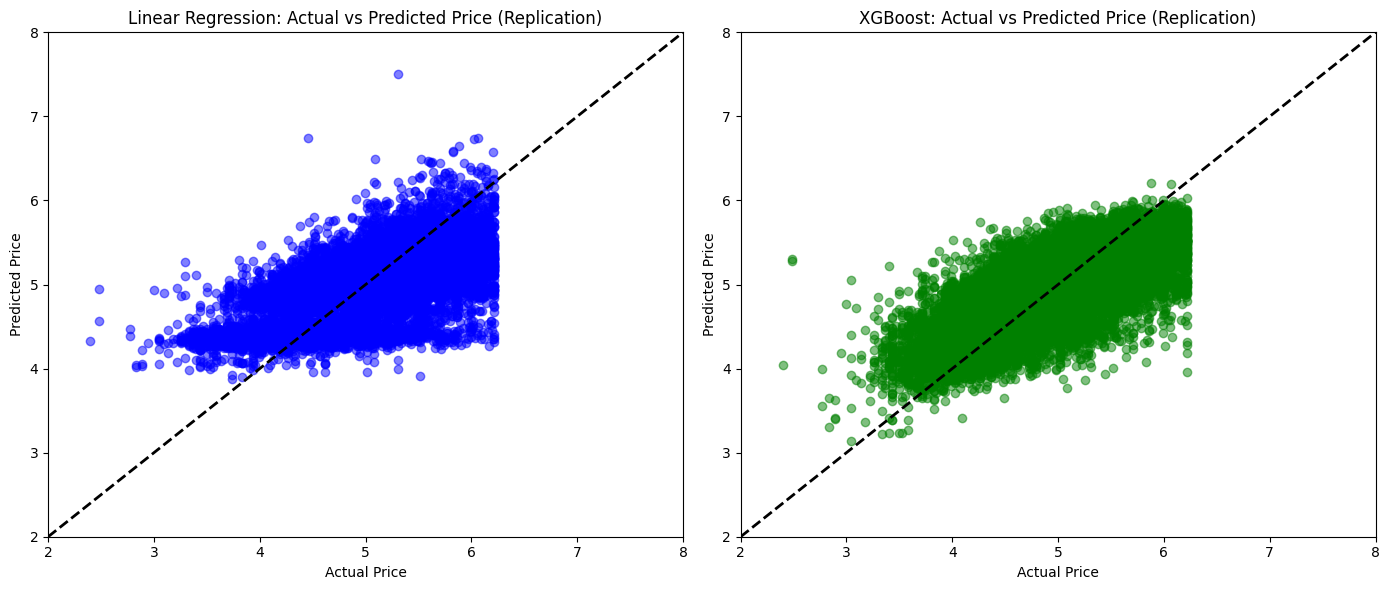

In [ ]:
# Fit the Linear Regression Model to the entire training data
linear_model.fit(X_train_replication_scaled, y_train_replication)

# Predictions on test data
y_pred_test_lr = linear_model.predict(X_test_replication_scaled)

# Calculate metrics for Linear Regression Model
rmse_lr_test = np.sqrt(mean_squared_error(y_test_replication, y_pred_test_lr))
r2_lr_test = r2_score(y_test_replication, y_pred_test_lr)

print("Linear Regression (Test Data)")
print(f"RMSE: {rmse_lr_test:.2f}")
print(f"R-squared: {r2_lr_test:.2f}")

# Fit the XGBoost Model to the entire training data
xgb_regressor.fit(X_train_replication_scaled, y_train_replication)

# Predictions on test data
y_pred_test_xgb = xgb_regressor.predict(X_test_replication_scaled)

# Calculate metrics for XGBoost Model
rmse_xgb_test = np.sqrt(mean_squared_error(y_test_replication, y_pred_test_xgb))
r2_xgb_test = r2_score(y_test_replication, y_pred_test_xgb)

print("XGBoost Regression (Test Data)")
print(f"RMSE: {rmse_xgb_test:.2f}")
print(f"R-squared: {r2_xgb_test:.2f}")

plt.figure(figsize=(14, 6))

# Define fixed axis limits
x_min, x_max = 2, 8  # Set limits explicitly

# Linear Regression Scatter Plot
plt.subplot(1, 2, 1)
plt.scatter(y_test_replication, y_pred_test_lr, alpha=0.5, color='blue')
plt.plot([x_min, x_max], [x_min, x_max], 'k--', lw=2)
plt.xlim(x_min, x_max)  # Set x-axis limits
plt.ylim(x_min, x_max)  # Set y-axis limits for consistency
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression: Actual vs Predicted Price (Replication)')

# XGBoost Scatter Plot
plt.subplot(1, 2, 2)
plt.scatter(y_test_replication, y_pred_test_xgb, alpha=0.5, color='green')
plt.plot([x_min, x_max], [x_min, x_max], 'k--', lw=2)
plt.xlim(x_min, x_max)  # Set x-axis limits
plt.ylim(x_min, x_max)  # Set y-axis limits for consistency
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('XGBoost: Actual vs Predicted Price (Replication)')

plt.tight_layout()
plt.show()


The baseline model will generate the same results for all 4 feature sets, because they all consist of the same listings in the train set.

Now we compare the four feature sets to each other.

In [ ]:
#Function to evaluate a model with cross-validation
def evaluate_model(model, X, y, cv):
    rmse_scores = []
    r2_scores = []
    
    for train_index, val_index in cv.split(X):
        X_fold_train, X_fold_val = X[train_index], X[val_index]
        y_fold_train, y_fold_val = y.iloc[train_index], y.iloc[val_index]
        model.fit(X_fold_train, y_fold_train)
        y_pred_val = model.predict(X_fold_val)
        rmse_scores.append(np.sqrt(mean_squared_error(y_fold_val, y_pred_val)))
        r2_scores.append(r2_score(y_fold_val, y_pred_val))
    
    return np.mean(rmse_scores), np.mean(r2_scores)


# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Feature set 1: label_encoded_train
features_train_1 = label_encoded_train.drop(columns=['price'])
target_train_1 = label_encoded_train['price']
scaler_1 = StandardScaler()
features_train_1_scaled = scaler_1.fit_transform(features_train_1)

features1_test = label_encoded_test.drop(columns=['price'])
features2_test = reviews_without_sentiment_listings_label_encoded_test.drop(columns=['price'])
features3_test = reviews_sentiment_listings_label_encoded_test.drop(columns=['price'])
features4_test = reviews_sentiment_including_price_test.drop(columns=['price'])

#Because the test labels are the same for all feature sets
target_test = label_encoded_test['price']

# Baseline model for Test set
baseline_mean_price_1 = target_train_1.mean()  # Use the mean of training data
baseline_rmse_test_1 = np.sqrt(mean_squared_error(target_test, [baseline_mean_price_1] * len(target_test)))

# Linear regression for feature set 1
linear_model_1 = LinearRegression()
rmse_lr_1, r2_lr_1 = evaluate_model(linear_model_1, features_train_1_scaled, target_train_1, kf)
linear_model_1.fit(features_train_1_scaled, target_train_1)  # Train on all training data
print("feature set 1 (Non-review related features) - Linear regression (5-fold cv)")
print(f"Mean RMSE: {rmse_lr_1:.2f}")
print(f"Mean R-squared: {r2_lr_1:.2f}")

# XGBoost for feature set 1
xgb_regressor_1 = XGBRegressor(random_state=42)
rmse_xgb_1, r2_xgb_1 = evaluate_model(xgb_regressor_1, features_train_1_scaled, target_train_1, kf)
xgb_regressor_1.fit(features_train_1_scaled, target_train_1)  # Train on all training data
print("Feature set 1 (Non-review related features) - XGBoost (5-fold cv)")
print(f"Mean RMSE: {rmse_xgb_1:.2f}")
print(f"Mean R-squared: {r2_xgb_1:.2f}")

# Predictions on test data
y_pred_test_lr_1 = linear_model_1.predict(scaler_1.transform(label_encoded_test.drop(columns=['price'])))
y_pred_test_xgb_1 = xgb_regressor_1.predict(scaler_1.transform(label_encoded_test.drop(columns=['price'])))

# Calculate metrics for Linear regression model
rmse_lr_test_1 = np.sqrt(mean_squared_error(label_encoded_test['price'], y_pred_test_lr_1))
r2_lr_test_1 = r2_score(label_encoded_test['price'], y_pred_test_lr_1)
print("Linear regression (Test data - Non-review related features)")
print(f"RMSE: {rmse_lr_test_1:.2f}")
print(f"R-squared: {r2_lr_test_1:.2f}")

# Calculate metrics for XGBoost model
rmse_xgb_test_1 = np.sqrt(mean_squared_error(label_encoded_test['price'], y_pred_test_xgb_1))
r2_xgb_test_1 = r2_score(label_encoded_test['price'], y_pred_test_xgb_1)
print("XGBoost regression (Test data - Non-review related features)")
print(f"RMSE: {rmse_xgb_test_1:.2f}")
print(f"R-squared: {r2_xgb_test_1:.2f}")


# Complete feature set excluding sentiment: reviews_without_sentiment_listings_label_encoded_train
features_train_2 = reviews_without_sentiment_listings_label_encoded_train.drop(columns=['price'])
target_train_2 = reviews_without_sentiment_listings_label_encoded_train['price']
scaler_2 = StandardScaler()
features_train_2_scaled = scaler_2.fit_transform(features_train_2)

# Linear regression for feature set 2
linear_model_2 = LinearRegression()
rmse_lr_2, r2_lr_2 = evaluate_model(linear_model_2, features_train_2_scaled, target_train_2, kf)
linear_model_2.fit(features_train_2_scaled, target_train_2)  # Train on all training data
print("Complete feature set excluding sentiment - Linear regression (5-fold cv)")
print(f"Mean RMSE: {rmse_lr_2:.2f}")
print(f"Mean R-squared: {r2_lr_2:.2f}")

# XGBoost for feature set 2
xgb_regressor_2 = XGBRegressor(random_state=42)
rmse_xgb_2, r2_xgb_2 = evaluate_model(xgb_regressor_2, features_train_2_scaled, target_train_2, kf)
xgb_regressor_2.fit(features_train_2_scaled, target_train_2)  # Train on all training data
print("Complete feature set excluding sentiment - XGBoost (5-fold cv)")
print(f"Mean RMSE: {rmse_xgb_2:.2f}")
print(f"Mean R-squared: {r2_xgb_2:.2f}")

# Predictions on test data
y_pred_test_lr_2 = linear_model_2.predict(scaler_2.transform(reviews_without_sentiment_listings_label_encoded_test.drop(columns=['price'])))
y_pred_test_xgb_2 = xgb_regressor_2.predict(scaler_2.transform(reviews_without_sentiment_listings_label_encoded_test.drop(columns=['price'])))

# Calculate metrics for linear regression model
rmse_lr_test_2 = np.sqrt(mean_squared_error(reviews_without_sentiment_listings_label_encoded_test['price'], y_pred_test_lr_2))
r2_lr_test_2 = r2_score(reviews_without_sentiment_listings_label_encoded_test['price'], y_pred_test_lr_2)
print("Linear regression (Test data - Complete feature set excluding sentiment)")
print(f"RMSE: {rmse_lr_test_2:.2f}")
print(f"R-squared: {r2_lr_test_2:.2f}")


# Calculate metrics for XGBoost model
rmse_xgb_test_2 = np.sqrt(mean_squared_error(reviews_without_sentiment_listings_label_encoded_test['price'], y_pred_test_xgb_2))
r2_xgb_test_2 = r2_score(reviews_without_sentiment_listings_label_encoded_test['price'], y_pred_test_xgb_2)
print("XGBoost regression (Test data - Complete feature set excluding sentiment)")
print(f"RMSE: {rmse_xgb_test_2:.2f}")
print(f"R-squared: {r2_xgb_test_2:.2f}")

# Complete feature set including sentiment: reviews_sentiment_listings_label_encoded_train
features_train_3 = reviews_sentiment_listings_label_encoded_train.drop(columns=['price'])
target_train_3 = reviews_sentiment_listings_label_encoded_train['price']
scaler_3 = StandardScaler()
features_train_3_scaled = scaler_3.fit_transform(features_train_3)

# Linear regression for feature set 3: Complete feature set including sentiment
linear_model_3 = LinearRegression()
rmse_lr_3, r2_lr_3 = evaluate_model(linear_model_3, features_train_3_scaled, target_train_3, kf)
linear_model_3.fit(features_train_3_scaled, target_train_3)  # Train on all training data
print("Complete feature set including sentiment- Linear regression (5-fold cv)")
print(f"Mean RMSE: {rmse_lr_3:.2f}")
print(f"Mean R-squared: {r2_lr_3:.2f}")

#XGBoost for feature set 3
xgb_regressor_3 = XGBRegressor(random_state=42)
rmse_xgb_3, r2_xgb_3 = evaluate_model(xgb_regressor_3, features_train_3_scaled, target_train_3, kf)
xgb_regressor_3.fit(features_train_3_scaled, target_train_3)  # Train on all training data
print("Complete feature set including sentiment - XGBoost (5-fold cv)")
print(f"Mean RMSE: {rmse_xgb_3:.2f}")
print(f"Mean R-squared: {r2_xgb_3:.2f}")

# Predictions on test data
y_pred_test_lr_3 = linear_model_3.predict(scaler_3.transform(reviews_sentiment_listings_label_encoded_test.drop(columns=['price'])))
y_pred_test_xgb_3 = xgb_regressor_3.predict(scaler_3.transform(reviews_sentiment_listings_label_encoded_test.drop(columns=['price'])))

# Calculate metrics for linear regression model
rmse_lr_test_3 = np.sqrt(mean_squared_error(reviews_sentiment_listings_label_encoded_test['price'], y_pred_test_lr_3))
r2_lr_test_3 = r2_score(reviews_sentiment_listings_label_encoded_test['price'], y_pred_test_lr_3)
print("Linear regression (Test data - Complete feature set including sentimentComplete feature set including sentiment)")
print(f"RMSE: {rmse_lr_test_3:.2f}")
print(f"R-squared: {r2_lr_test_3:.2f}")

# Calculate metrics for xgboost model
rmse_xgb_test_3 = np.sqrt(mean_squared_error(reviews_sentiment_listings_label_encoded_test['price'], y_pred_test_xgb_3))
r2_xgb_test_3 = r2_score(reviews_sentiment_listings_label_encoded_test['price'], y_pred_test_xgb_3)
print("XGBoost regression (Test data - Complete feature set including sentiment)")
print(f"RSME: {rmse_xgb_test_3:.2f}")
print(f"R-squared: {r2_xgb_test_3:.2f}")

# Only review-related features: reviews_sentiment_including_price_train
features_train_4 = reviews_sentiment_including_price_train.drop(columns=['price'])
target_train_4 = reviews_sentiment_including_price_train['price']
scaler_4 = StandardScaler()
features_train_4_scaled = scaler_4.fit_transform(features_train_4)

# Linear regression for feature set 4
linear_model_4 = LinearRegression()
rmse_lr_4, r2_lr_4 = evaluate_model(linear_model_4, features_train_4_scaled, target_train_4, kf)
linear_model_4.fit(features_train_4_scaled, target_train_4)  # Train on all training data
print("Only review-related features - Linear regression (5-fold cv)")
print(f"Mean RSME: {rmse_lr_4:.2f}")
print(f"Mean R-squared: {r2_lr_4:.2f}")

# XGBoost for feature set 4
xgb_regressor_4 = XGBRegressor(random_state=42)
rmse_xgb_4, r2_xgb_4 = evaluate_model(xgb_regressor_4, features_train_4_scaled, target_train_4, kf)
xgb_regressor_4.fit(features_train_4_scaled, target_train_4)  # Train on all training data
print("Only review-related features - XGBoost (5-fold cv)")
print(f"Mean RMSE: {rmse_xgb_4:.2f}")
print(f"Mean R-squared: {r2_xgb_4:.2f}")

# Predictions on test data
y_pred_test_lr_4 = linear_model_4.predict(scaler_4.transform(reviews_sentiment_including_price_test.drop(columns=['price'])))
y_pred_test_xgb_4 = xgb_regressor_4.predict(scaler_4.transform(reviews_sentiment_including_price_test.drop(columns=['price'])))

# Calculate metrics for linear regression model
rmse_lr_test_4 = np.sqrt(mean_squared_error(reviews_sentiment_including_price_test['price'], y_pred_test_lr_4))
r2_lr_test_4 = r2_score(reviews_sentiment_including_price_test['price'], y_pred_test_lr_4)
print("Linear regression (Test data - Only review-related features)")
print(f"RMSE: {rmse_lr_test_4:.2f}")
print(f"R-squared: {r2_lr_test_4:.2f}")

# Calculate metrics for xgboost model
rmse_xgb_test_4 = np.sqrt(mean_squared_error(reviews_sentiment_including_price_test['price'], y_pred_test_xgb_4))
r2_xgb_test_4 = r2_score(reviews_sentiment_including_price_test['price'], y_pred_test_xgb_4)
print("XGBoost regression (Test data - Only review-related features)")
print(f"RMSE: {rmse_xgb_test_4:.2f}")
print(f"R-squared: {r2_xgb_test_4:.2f}")


feature set 1 (Non-review related features) - Linear regression (5-fold cv)
Mean RMSE: 0.46
Mean R-squared: 0.56
Feature set 1 (Non-review related features) - XGBoost (5-fold cv)
Mean RMSE: 0.34
Mean R-squared: 0.76
Linear regression (Test data - Non-review related features)
RMSE: 0.46
R-squared: 0.56
XGBoost regression (Test data - Non-review related features)
RMSE: 0.34
R-squared: 0.77
Complete feature set excluding sentiment - Linear regression (5-fold cv)
Mean RMSE: 0.45
Mean R-squared: 0.58
Complete feature set excluding sentiment - XGBoost (5-fold cv)
Mean RMSE: 0.33
Mean R-squared: 0.78
Linear regression (Test data - Complete feature set excluding sentiment)
RMSE: 0.45
R-squared: 0.58
XGBoost regression (Test data - Complete feature set excluding sentiment)
RMSE: 0.33
R-squared: 0.78
Complete feature set including sentiment- Linear regression (5-fold cv)
Mean RMSE: 0.45
Mean R-squared: 0.59
Complete feature set including sentiment - XGBoost (5-fold cv)
Mean RMSE: 0.33
Mean R-squ

In [41]:
# Baseline RMSE for each feature set's extra test set
baseline_rmse_extra_test_1 = np.sqrt(mean_squared_error(extra_test_feature_set1['price'], [baseline_mean_price_1] * len(extra_test_feature_set1)))
baseline_rmse_extra_test_2 = np.sqrt(mean_squared_error(extra_test_feature_set2['price'], [baseline_mean_price_1] * len(extra_test_feature_set2)))
baseline_rmse_extra_test_3 = np.sqrt(mean_squared_error(extra_test_feature_set3['price'], [baseline_mean_price_1] * len(extra_test_feature_set3)))
baseline_rmse_extra_test_4 = np.sqrt(mean_squared_error(extra_test_feature_set4['price'], [baseline_mean_price_1] * len(extra_test_feature_set4)))

print("Baseline RMSE for each feature set:")
print(f"Baseline RMSE (Feature Set 1): {baseline_rmse_extra_test_1:.2f}")
print(f"Baseline RMSE (Feature Set 2): {baseline_rmse_extra_test_2:.2f}")
print(f"Baseline RMSE (Feature Set 3): {baseline_rmse_extra_test_3:.2f}")
print(f"Baseline RMSE (Feature Set 4): {baseline_rmse_extra_test_4:.2f}")

# Linear regression predictions for separate test sets
y_pred_extra_test_lr_1 = linear_model_1.predict(scaler_1.transform(extra_test_feature_set1.drop(columns=['price'])))
y_pred_extra_test_lr_2 = linear_model_2.predict(scaler_2.transform(extra_test_feature_set2.drop(columns=['price'])))
y_pred_extra_test_lr_3 = linear_model_3.predict(scaler_3.transform(extra_test_feature_set3.drop(columns=['price'])))
y_pred_extra_test_lr_4 = linear_model_4.predict(scaler_4.transform(extra_test_feature_set4.drop(columns=['price'])))

# XGBoost predictions for separate test sets
y_pred_extra_test_xgb_1 = xgb_regressor_1.predict(scaler_1.transform(extra_test_feature_set1.drop(columns=['price'])))
y_pred_extra_test_xgb_2 = xgb_regressor_2.predict(scaler_2.transform(extra_test_feature_set2.drop(columns=['price'])))
y_pred_extra_test_xgb_3 = xgb_regressor_3.predict(scaler_3.transform(extra_test_feature_set3.drop(columns=['price'])))
y_pred_extra_test_xgb_4 = xgb_regressor_4.predict(scaler_4.transform(extra_test_feature_set4.drop(columns=['price'])))

# Collect predictions and labels for evaluation
lr_predictions = [
    (y_pred_extra_test_lr_1, extra_test_feature_set1['price'], "Non-review related features"),
    (y_pred_extra_test_lr_2, extra_test_feature_set2['price'], "Complete feature set excluding sentiment"),
    (y_pred_extra_test_lr_3, extra_test_feature_set3['price'], "Complete feature set including sentiment"),
    (y_pred_extra_test_lr_4, extra_test_feature_set4['price'], "Only review-related features")
]

xgb_predictions = [
    (y_pred_extra_test_xgb_1, extra_test_feature_set1['price'], "Non-review related features"),
    (y_pred_extra_test_xgb_2, extra_test_feature_set2['price'], "Complete feature set excluding sentiment"),
    (y_pred_extra_test_xgb_3, extra_test_feature_set3['price'], "Complete feature set including sentiment"),
    (y_pred_extra_test_xgb_4, extra_test_feature_set4['price'], "Only review-related features")
]

# Evaluate and store results
results = []
for predictions, target, label in lr_predictions + xgb_predictions:
    rmse = np.sqrt(mean_squared_error(target, predictions))
    r2 = r2_score(target, predictions)
    results.append((label, rmse, r2))

# Print results
print("\nModel Performance on Separate Test Sets:")
print(f"{'Model':<50}{'RMSE':<10}{'R-squared':<10}")
for label, rmse, r2 in results:
    print(f"{label:<50}{rmse:<10.2f}{r2:<10.2f}")




Baseline RMSE for each feature set:
Baseline RMSE (Feature Set 1): 0.80
Baseline RMSE (Feature Set 2): 0.80
Baseline RMSE (Feature Set 3): 0.80
Baseline RMSE (Feature Set 4): 0.80

Model Performance on Separate Test Sets:
Model                                             RMSE      R-squared 
Non-review related features                       0.47      0.55      
Complete feature set excluding sentiment          0.47      0.55      
Complete feature set including sentiment          0.47      0.54      
Only review-related features                      0.79      -0.31     
Non-review related features                       0.75      -0.16     
Complete feature set excluding sentiment          0.83      -0.43     
Complete feature set including sentiment          0.76      -0.20     
Only review-related features                      0.77      -0.25     


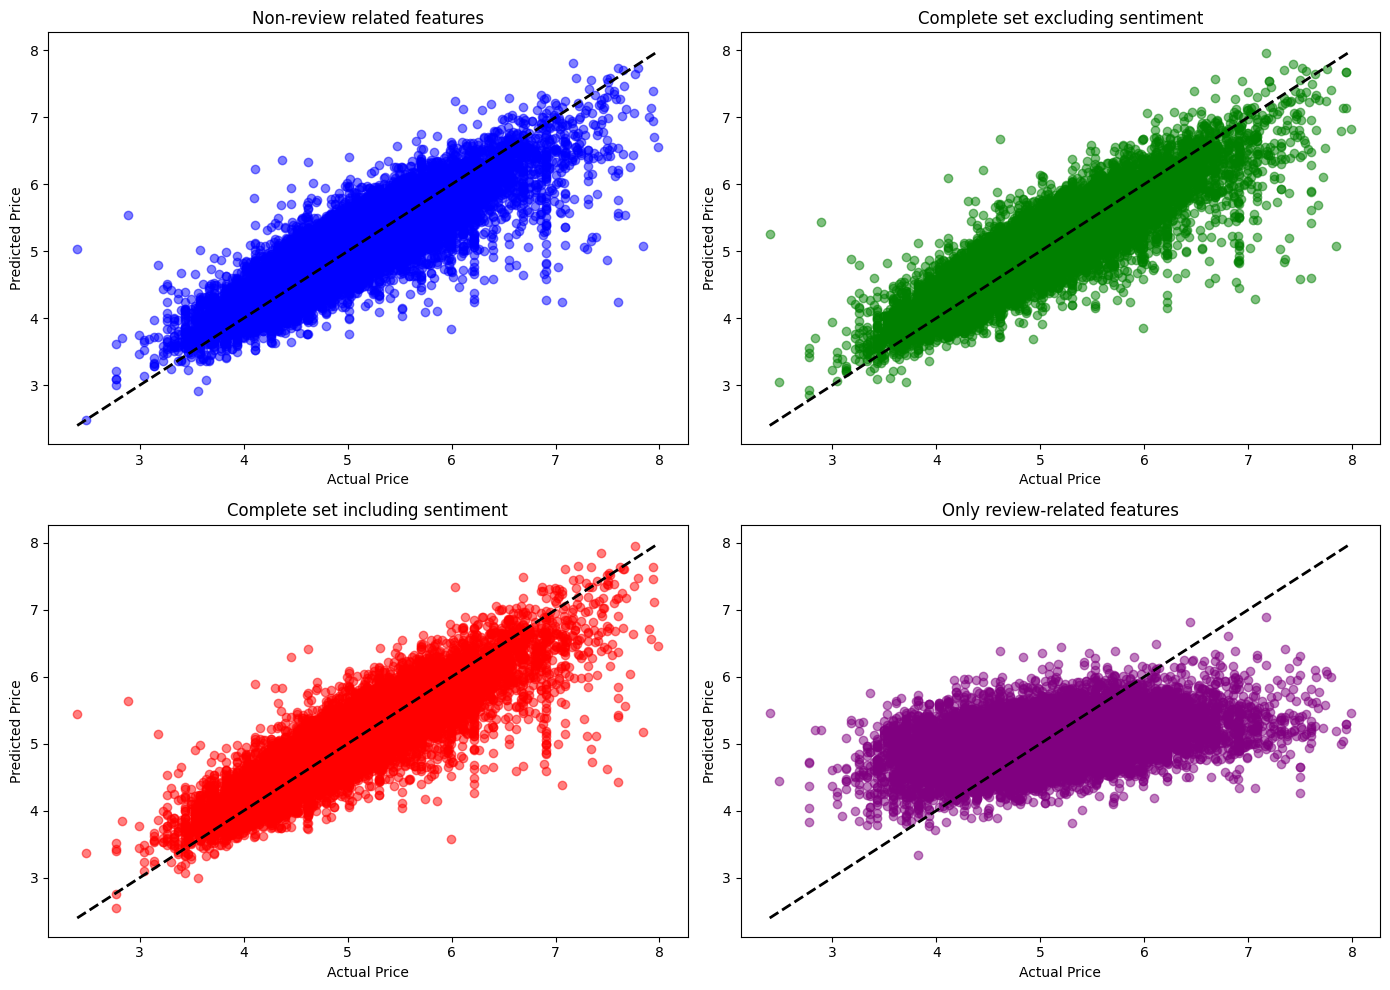

In [42]:
def plot_subplot_scatter_actual_vs_predicted(y_actual_list, y_pred_list, feature_set_names):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Create a 2x2 grid of subplots
    axes = axes.flatten()  # Flatten the axes for easy iteration
    
    colors = ['blue', 'green', 'red', 'purple']  # Assign different colors to each feature set
    for i, (y_actual, y_pred, name, color) in enumerate(zip(y_actual_list, y_pred_list, feature_set_names, colors)):
        ax = axes[i]
        ax.scatter(y_actual, y_pred, alpha=0.5, color=color)
        ax.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--', lw=2)  # Diagonal reference line
        ax.set_title(f'{name}')
        ax.set_xlabel('Actual Price')
        ax.set_ylabel('Predicted Price')
    
    plt.tight_layout()
    plt.show()

# Collect predictions and actual values for all feature sets
y_actual_list = [
    label_encoded_test['price'],
    reviews_without_sentiment_listings_label_encoded_test['price'],
    reviews_sentiment_listings_label_encoded_test['price'],
    reviews_sentiment_including_price_test['price']
]
y_pred_list = [
    y_pred_test_xgb_1,
    y_pred_test_xgb_2,
    y_pred_test_xgb_3,
    y_pred_test_xgb_4
]
feature_set_names = [
    'Non-review related features',
    'Complete set excluding sentiment',
    'Complete set including sentiment',
    'Only review-related features'
]

# Plot the scatter plots as subplots
plot_subplot_scatter_actual_vs_predicted(y_actual_list, y_pred_list, feature_set_names)


In [43]:
pip install statsmodels

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   -------- ------------------------------- 2.1/9.8 MB 10.6 MB/s eta 0:00:01
   --------------------- ------------------ 5.2/9.8 MB 12.8 MB/s eta 0:00:01
   ---------------------------------- ----- 8.4/9.8 MB 13.8 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 13.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


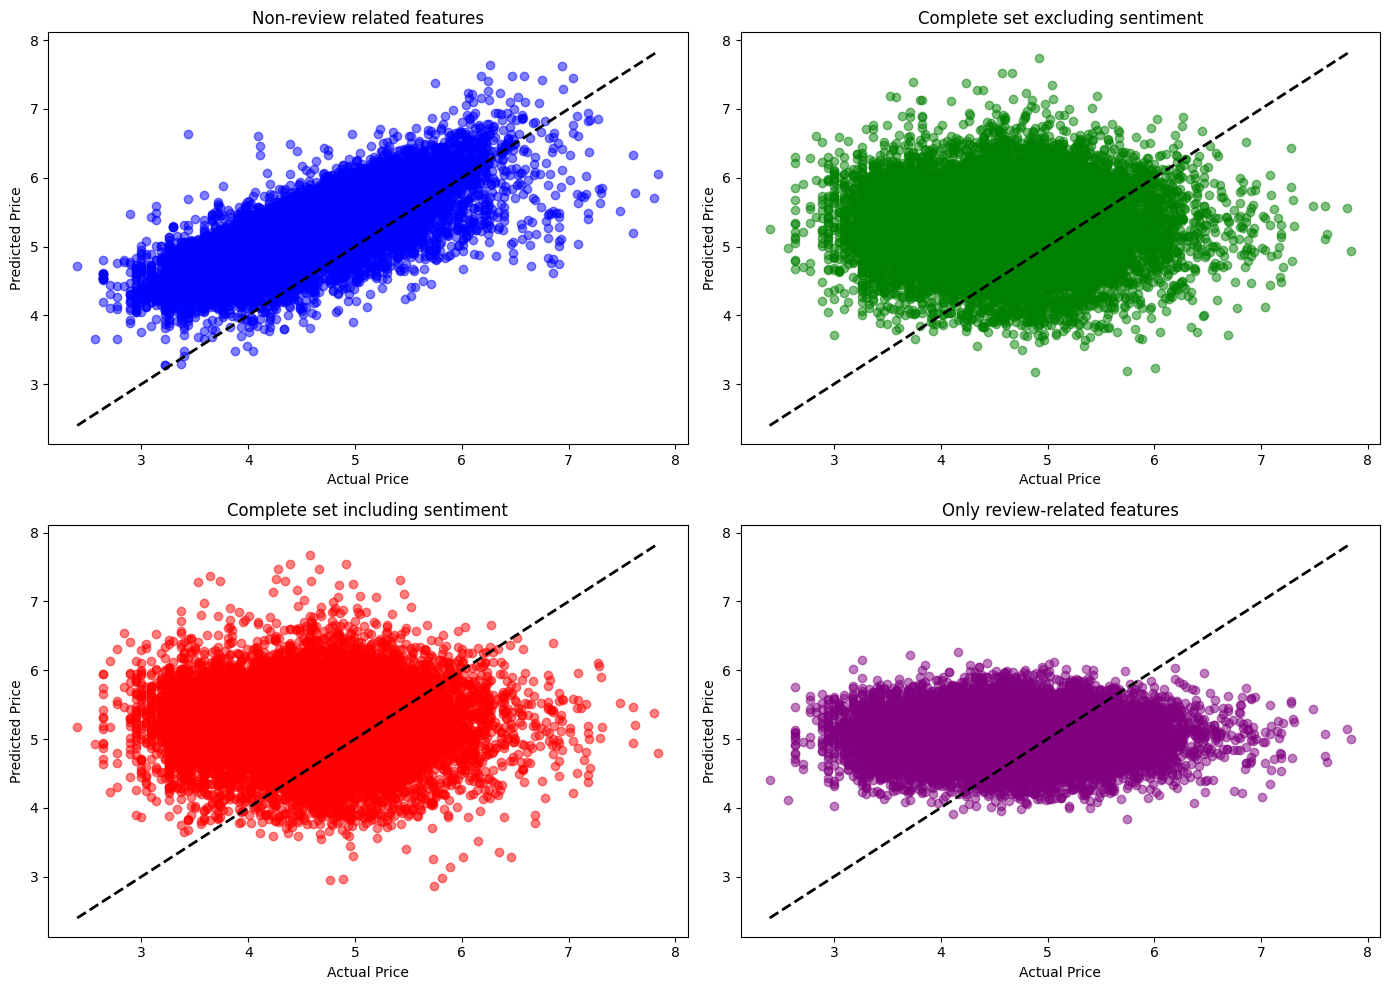

In [23]:
# Actual values from the extra test set
y_actual_extra_test = extra_test_feature_set1['price']

# Collect predictions and actual values for all feature sets
y_actual_list_extra = [
    extra_test_feature_set1['price'],
    extra_test_feature_set1['price'],
    extra_test_feature_set1['price'],
    extra_test_feature_set1['price']
]

# Predictions for all feature sets
y_pred_extra_test_list = [
    y_pred_extra_test_xgb_1,
    y_pred_extra_test_xgb_2,
    y_pred_extra_test_xgb_3,
    y_pred_extra_test_xgb_4
]

# Feature set names
feature_set_names_extra_test = [
    'Non-review related features',
    'Complete set excluding sentiment',
    'Complete set including sentiment',
    'Only review-related features'
]

# Plot the scatter plots for the extra test set
plot_subplot_scatter_actual_vs_predicted(y_actual_list_extra, y_pred_extra_test_list, feature_set_names_extra_test)

In [32]:
print(extra_test_feature_set1['price'].head())
print(extra_test_feature_set2['price'].head())




0    4.394449
1    4.394449
2    3.931826
3    3.931826
4    4.454347
Name: price, dtype: float64
0    3.465736
1    4.653960
2    4.744932
3    4.204693
4    4.394449
Name: price, dtype: float64


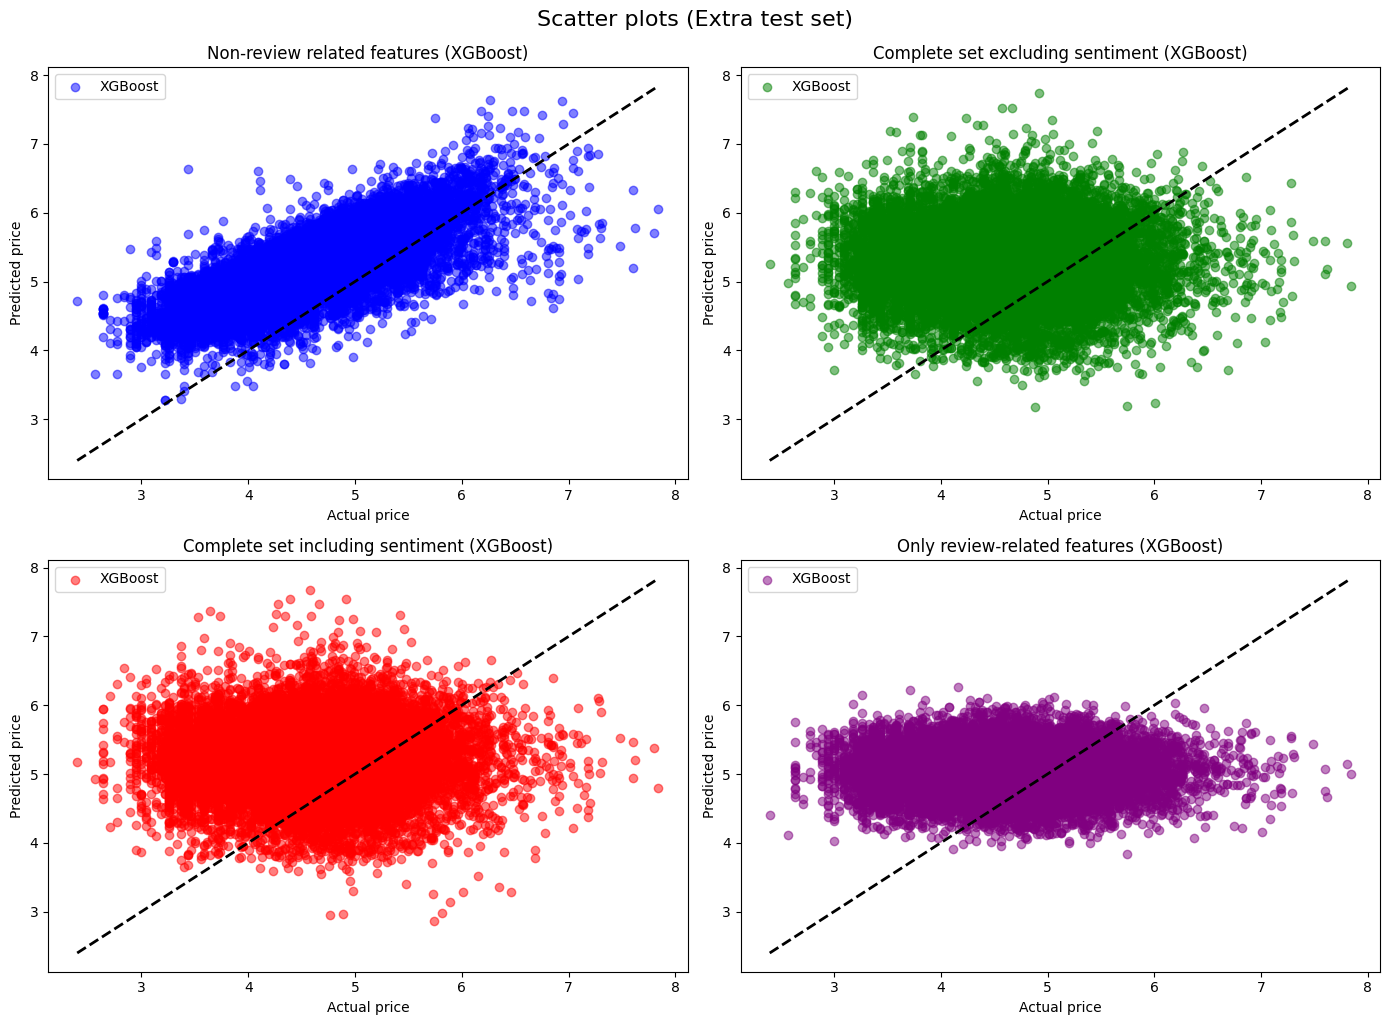

In [ ]:

def plot_actual_vs_predicted_scatter_xgb(target, predictions_list, feature_set_names):
    """
    Generates scatter plots for actual vs. predicted values for XGBoost models.

    Parameters:
        target (array-like): The actual target values (ground truth).
        predictions_list (list of array-like): A list of predicted values for each feature set.
        feature_set_names (list of str): Names of the feature sets corresponding to the predictions.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2x2 grid of subplots
    axes = axes.flatten()  # Flatten the grid for easier iteration
    colors = ['blue', 'green', 'red', 'purple']  # Colors for the plots
    
    for i, (predictions, feature_name, color) in enumerate(zip(predictions_list, feature_set_names, colors)):
        ax = axes[i]
        ax.scatter(target, predictions, alpha=0.5, color=color, label='XGBoost')
        ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=2)  # Diagonal reference line
        ax.set_title(f'{feature_name} (XGBoost)')
        ax.set_xlabel('Actual price')
        ax.set_ylabel('Predicted price')
        ax.legend()

    plt.tight_layout()
    plt.suptitle('Scatter plots (Extra test set)', y=1.02, fontsize=16)
    plt.show()

# Actual target values
target_extra_test = extra_test_feature_set1['price']

# XGBoost Predictions
xgb_predictions = [
    y_pred_extra_test1_xgb_1,
    y_pred_extra_test1_xgb_2,
    y_pred_extra_test1_xgb_3,
    y_pred_extra_test1_xgb_4
]

# Feature Set Names
feature_set_names = [
    'Non-review related features',
    'Complete set excluding sentiment',
    'Complete set including sentiment',
    'Only review-related features'
]

# Plot XGBoost Scatter Plots
plot_actual_vs_predicted_scatter_xgb(
    target=target_extra_test,
    predictions_list=xgb_predictions,
    feature_set_names=feature_set_names
)



Training model for Feature set 1...


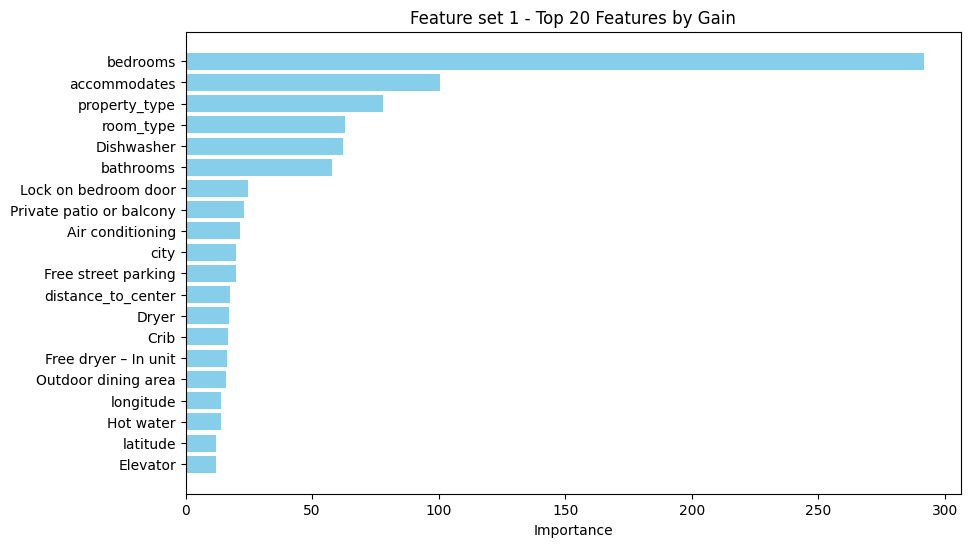

Training model for Feature set 2...


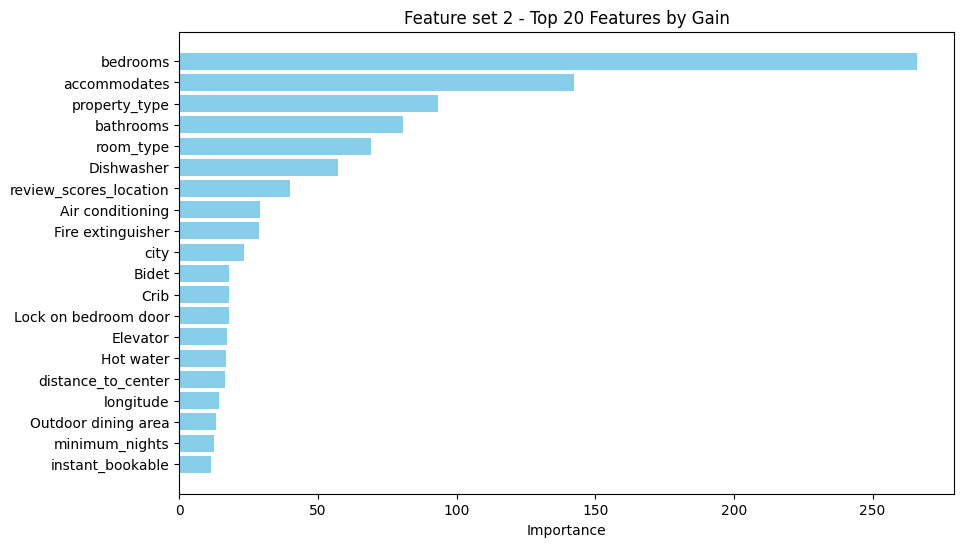

Training model for Feature set 3...


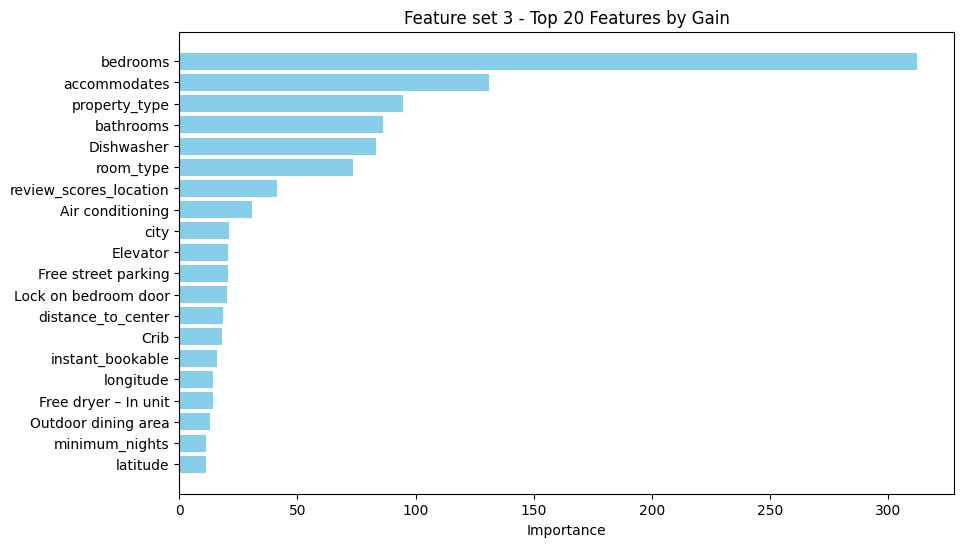

Training model for Feature set 4...


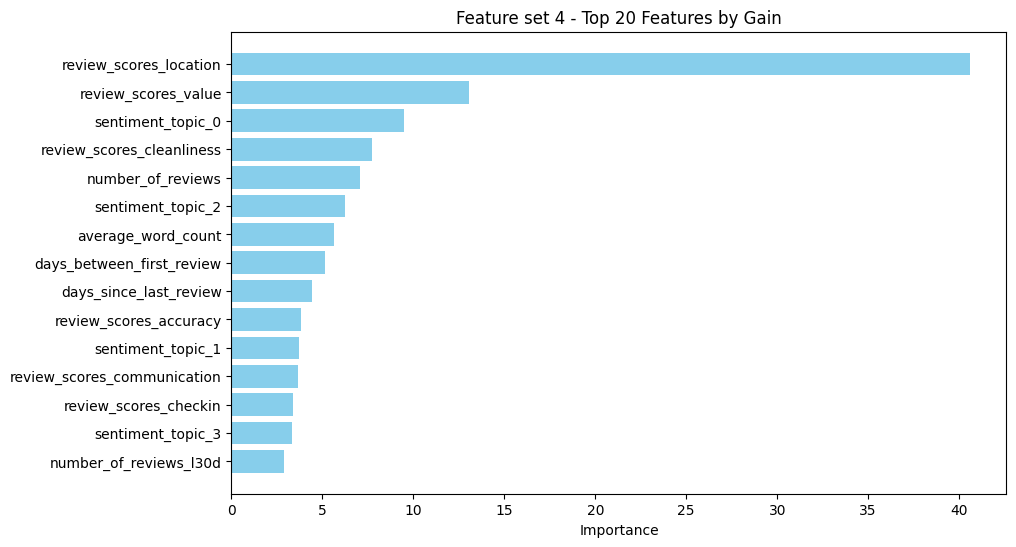

In [ ]:
# Function to train an XGBoost model
def train_xgboost(X, y):
    """
    Train an XGBoost regressor model on the given dataset.
    
    Parameters:
    - X: Feature matrix (pandas DataFrame)
    - y: Target variable (pandas Series)
    
    Returns:
    - model: Trained XGBoost model
    """
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X, y)
    return model

# Function to plot feature importance
def plot_xgboost_feature_importance(model, feature_names, feature_set_name, importance_type='gain', top_n=20):
    """
    Plot feature importance for an XGBoost model.

    Parameters:
    - model: Trained XGBoost model
    - feature_names: List of feature names
    - feature_set_name: Name of the feature set for the title
    - importance_type: Type of importance to plot ('gain', 'weight', 'cover')
    - top_n: Number of top features to plot
    """
    # Extract feature importance
    importance = model.get_booster().get_score(importance_type=importance_type)
    # Handle feature mapping for XGBoost format
    importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
    importance_df['Feature'] = importance_df['Feature'].apply(
        lambda x: feature_names[int(x[1:])] if x.startswith('f') else x
    )
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title(f'{feature_set_name} - Top {top_n} Features by {importance_type.capitalize()}')
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.show()

# Feature sets and corresponding target variable
datasets = [
    (label_encoded_train.drop(columns=['price'], errors='ignore'), label_encoded_train['price'], "Feature set 1"),
    (reviews_without_sentiment_listings_label_encoded_train.drop(columns=['price'], errors='ignore'),
     reviews_without_sentiment_listings_label_encoded_train['price'], "Feature set 2"),
    (reviews_sentiment_listings_label_encoded_train.drop(columns=['price'], errors='ignore'),
     reviews_sentiment_listings_label_encoded_train['price'], "Feature set 3"),
    (reviews_sentiment_including_price_train.drop(columns=['price'], errors='ignore'),
     reviews_sentiment_including_price_train['price'], "Feature set 4"),
]

# Analyze feature importance for each dataset
for X, y, name in datasets:
    print(f"Training model for {name}...")
    model = train_xgboost(X, y)
    plot_xgboost_feature_importance(model, X.columns, name, importance_type='gain', top_n=20)
